# **Brooklyn Pizza Restaurant Analysis**

Joseph Lardie

December 2023

# **Imports**

In [1]:
#Numpy
import numpy as np

#Pandas
import pandas as pd

#Seaborn
import seaborn as sns

#matplotlib
import matplotlib.pyplot as plt
import plotly
%matplotlib inline

from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords

#Geospacial
import geopandas as gpd
import folium

#Sklearn preprocessing
from sklearn import preprocessing,set_config
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer

#Scipy
from scipy import stats
from scipy.stats import norm

# Warnings
import warnings
warnings.filterwarnings("ignore")
set_config(display = 'diagram')

# **Import Data**

In [2]:
# Loading merged Brooklyn Pizza Restaurants Data
mdf = pd.read_csv('mdf')

In [3]:
# Ensuring the data loaded correctly
mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CAMIS                  506 non-null    int64  
 1   DBA                    506 non-null    object 
 2   BORO                   506 non-null    object 
 3   BUILDING               506 non-null    object 
 4   STREET                 506 non-null    object 
 5   ZIPCODE                502 non-null    float64
 6   CUISINE DESCRIPTION    506 non-null    object 
 7   INSPECTION DATE        506 non-null    object 
 8   ACTION                 506 non-null    object 
 9   VIOLATION CODE         504 non-null    object 
 10  VIOLATION DESCRIPTION  504 non-null    object 
 11  CRITICAL FLAG          506 non-null    object 
 12  SCORE                  506 non-null    float64
 13  GRADE                  506 non-null    object 
 14  GRADE DATE             499 non-null    object 
 15  INSPEC

# **Data Cleaning**

## **Longitude and Latitude**

In [4]:
# Function to clean up longitude and latitude
def clean_coordinates(coord):
    try:
        # Convert to float
        coord = float(coord)
        
        # Ensure that longitude is in the range [-180, 180]
        if coord < -180 or coord > 180:
            return None  
        else:
            return coord
    except ValueError:
        return None  

# Apply the cleaning function to 'Longitude' and 'Latitude' columns
mdf['Longitude'] = mdf['Longitude'].apply(clean_coordinates)
mdf['Latitude'] = mdf['Latitude'].apply(clean_coordinates)

# Drop rows with missing or invalid coordinates
mdf = mdf.dropna(subset=['Longitude', 'Latitude'])

## **Outliers**

In [5]:
# Function to calculate z-score for a column
def calculate_zscore(column):
    z_scores = (column - column.mean()) / column.std()
    return z_scores

# Calculate z-scores for 'Longitude' and 'Latitude'
z_scores_longitude = calculate_zscore(mdf['Longitude'])
z_scores_latitude = calculate_zscore(mdf['Latitude'])

# Set a threshold for z-scores (e.g., 3 standard deviations)
z_threshold = 3

# Identify and remove outliers based on the threshold
outliers = (np.abs(z_scores_longitude) > z_threshold) | (np.abs(z_scores_latitude) > z_threshold)
mdf = mdf[~outliers]

# **Feature Engineering**

In [6]:
# Create a new column 'Restaurant Chain Indicator'
mdf['Chain Indicator'] = mdf['DBA'].duplicated(keep=False)

In [7]:
# Create a new column 'Full Address'
mdf['Full Address'] = mdf['BUILDING'] + ' ' + mdf['STREET']

In [8]:
# Define size categories
size_bins = [50, 100, 200, np.inf]
size_labels = ['Small', 'Medium', 'Large']

# Create 'Size Category' column
mdf['Size Category'] = pd.cut(mdf['review_count'], bins=size_bins, labels=size_labels)

# **Visualizations**

## **Top 20 rated**

In [9]:
# Sort in descending order and select the top 20 rated restaurants
top_rated_restaurants = mdf.sort_values(by='rating', ascending=False).head(20)
print(top_rated_restaurants)

        CAMIS                     DBA      BORO BUILDING               STREET  \
351  50102007  ROME TO BROOKLYN PIZZA  Brooklyn      755         GRAND STREET   
350  50102007  ROME TO BROOKLYN PIZZA  Brooklyn      755         GRAND STREET   
349  50102007  ROME TO BROOKLYN PIZZA  Brooklyn      755         GRAND STREET   
348  50102007  ROME TO BROOKLYN PIZZA  Brooklyn      755         GRAND STREET   
347  50102007  ROME TO BROOKLYN PIZZA  Brooklyn      755         GRAND STREET   
505  50115949                  CROSTA  Brooklyn      486             6 AVENUE   
94   50056980                 FAZIO'S  Brooklyn      709    KNICKERBOCKER AVE   
386  50089510            ROSA'S PIZZA  Brooklyn      374  METROPOLITAN AVENUE   
390  50089510            ROSA'S PIZZA  Brooklyn      374  METROPOLITAN AVENUE   
96   50056980                 FAZIO'S  Brooklyn      709    KNICKERBOCKER AVE   
95   50056980                 FAZIO'S  Brooklyn      709    KNICKERBOCKER AVE   
93   50056980               

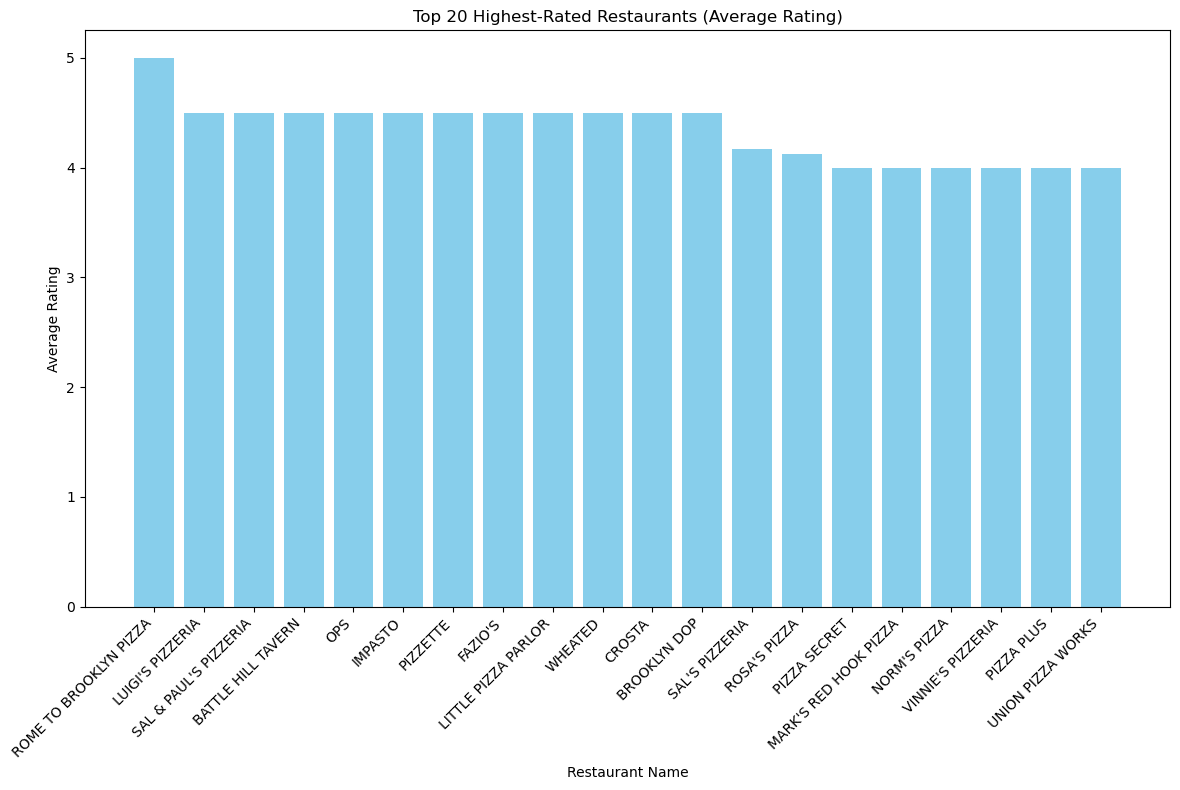

In [10]:
# Group by 'name' and calculate the mean rating for each restaurant
mean_ratings = mdf.groupby('name')['rating'].mean().reset_index()

# Sort by mean rating in descending order and select the top 20
top_rated_restaurants = mean_ratings.sort_values(by='rating', ascending=False).head(20)

# Create a vertical bar plot
plt.figure(figsize=(12, 8))
plt.bar(top_rated_restaurants['name'], top_rated_restaurants['rating'], color='skyblue')
plt.xlabel('Restaurant Name')
plt.ylabel('Average Rating')
plt.title('Top 20 Highest-Rated Restaurants (Average Rating)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

## **Top 20 review count**

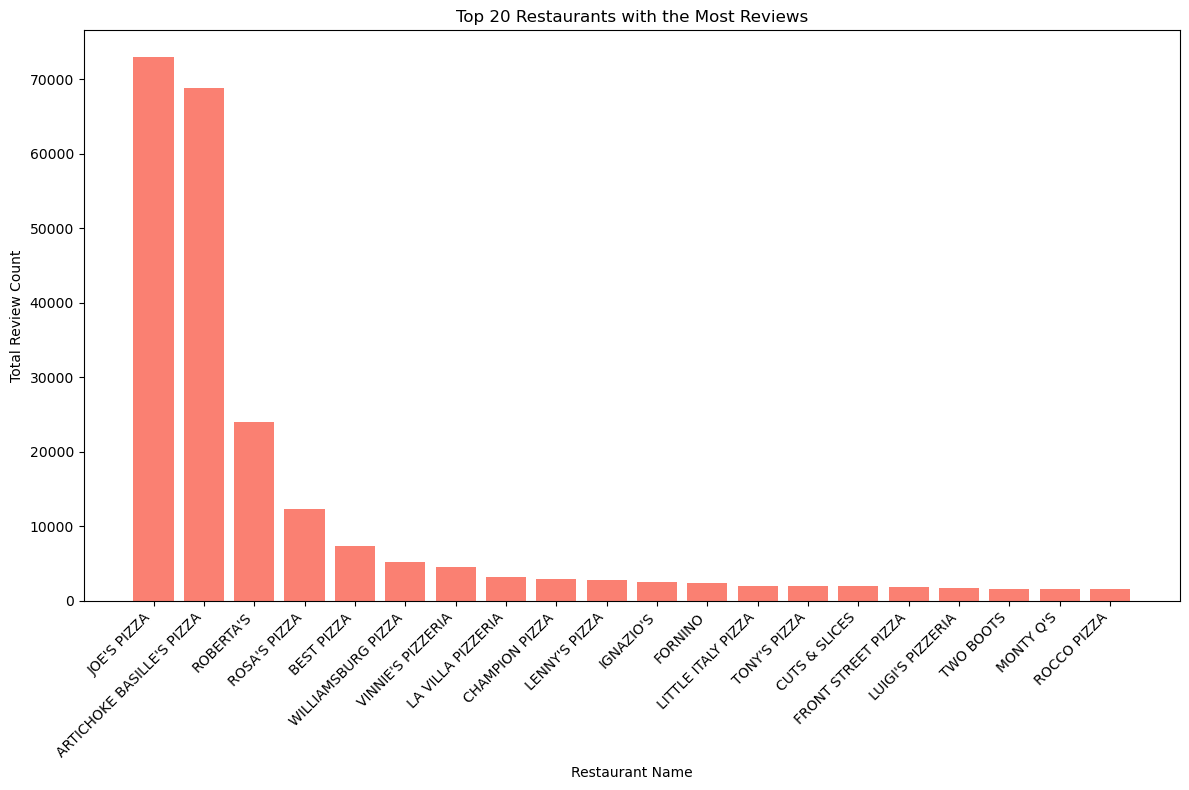

In [11]:
# Group by 'name' and calculate the total review count for each restaurant
total_reviews = mdf.groupby('name')['review_count'].sum().reset_index()

# Sort by total review count in descending order and select the top 20
top_reviewed_restaurants = total_reviews.sort_values(by='review_count', ascending=False).head(20)

# Create a vertical bar plot
plt.figure(figsize=(12, 8))
plt.bar(top_reviewed_restaurants['name'], top_reviewed_restaurants['review_count'], color='salmon')
plt.xlabel('Restaurant Name')
plt.ylabel('Total Review Count')
plt.title('Top 20 Restaurants with the Most Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

## **Size Category count**

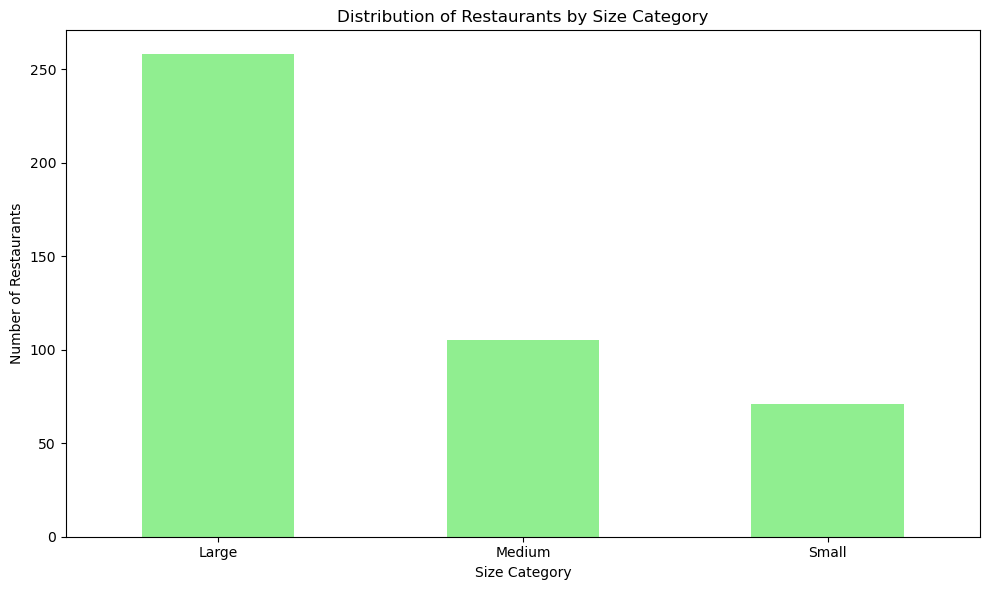

In [12]:
# Count the number of restaurants in each size category
size_category_counts = mdf['Size Category'].value_counts()

# Create a vertical bar plot
plt.figure(figsize=(10, 6))
size_category_counts.plot(kind='bar', color='lightgreen')
plt.xlabel('Size Category')
plt.ylabel('Number of Restaurants')
plt.title('Distribution of Restaurants by Size Category')
plt.xticks(rotation=0, ha='center')  # Rotate x-axis labels if needed
plt.tight_layout()

# Show the plot
plt.show()

## **Geospatial**

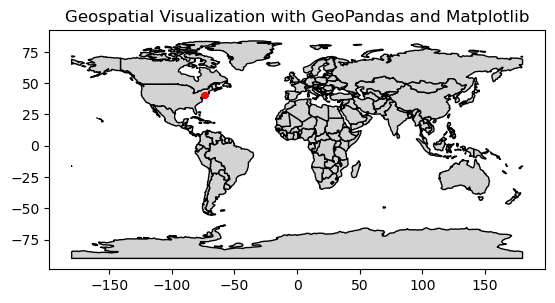

In [13]:
# Create a GeoDataFrame from the DataFrame
geometry = gpd.points_from_xy(mdf['Longitude'], mdf['Latitude'])
gdf = gpd.GeoDataFrame(mdf, geometry=geometry)

# Plot using GeoPandas and Matplotlib
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, marker='o', color='red', markersize=10, alpha=0.5)
plt.title('Geospatial Visualization with GeoPandas and Matplotlib')
plt.show()

# Creating an interactive map using Folium
m = folium.Map(location=[mdf['Latitude'].mean(), mdf['Longitude'].mean()], zoom_start=1)

for index, row in mdf.iterrows():
    popup_content = (
        f"Name: {row['name']}<br>"
        f"Latitude: {row['Latitude']}, Longitude: {row['Longitude']}<br>"
        f"Rating: {row['rating']}<br>"
        f"Review Count: {row['review_count']}<br>"
        f"SCORE: {row['SCORE']}<br>"
        f"Size Category: {row['Size Category']}<br>"
        f"Full Address: {row['Full Address']}<br>"
        f"Chain Indicator: {row['Chain Indicator']}<br>"
        f"Transaction: {row['transactions']}<br>"
        f"Grade: {row['GRADE']}"
    )

    # Create a marker with the customized popup content and add it to the map
    folium.Marker([row['Latitude'], row['Longitude']], popup=folium.Popup(popup_content, max_width=300)).add_to(m)

# Save the map to an HTML file
m.save('folium_map.html')

# Showing the geospatial viz
m